In [1]:
!pip install openai-clip
!pip install datasets
!pip install torch
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=540410f1c79597ddaea51b79208ed0c9355dd2d0c7dcd96563be267b9d52939c
  Stored in directory: /root/.cache/pip/wheels/0d/17/90/042948fd2e2a87f1dcf6db6d438cad015c49db0c53d1d9c7dc
Successfully built openai-clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np

X = np.load('/content/drive/MyDrive/SafeReels-664/Extracted_Frames/X_data.npy')
y = np.load('/content/drive/MyDrive/SafeReels-664/Extracted_Frames/y_data.npy')

In [4]:
X.shape

(664, 5, 224, 224, 3)

In [5]:
y.shape

(664,)

In [6]:
X = X.reshape(-1, 224, 224, 3)
y = np.repeat(y, 5)

In [7]:
X.shape

(3320, 224, 224, 3)

In [8]:
y.shape

(3320,)

In [9]:
from PIL import Image

def data_generator(X, y):
    for img, label in zip(X, y):
        img = np.squeeze(img)  # Remove extra dimensions if present
        img = Image.fromarray(np.uint8(img))  # Convert to PIL image
        yield {"image": img, "labels": label}

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
from datasets import Dataset

train_dataset = Dataset.from_generator(lambda: data_generator(X_train, y_train))
test_dataset = Dataset.from_generator(lambda: data_generator(X_test, y_test))

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
train_dataset

Dataset({
    features: ['image', 'labels'],
    num_rows: 2656
})

In [13]:
entry = train_dataset[0]
entry

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'labels': 0}

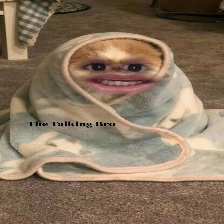

In [14]:
image = entry['image']
image

In [15]:
dataset = train_dataset

In [16]:
import clip
import torch

# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

100%|███████████████████████████████████████| 338M/338M [00:17<00:00, 20.3MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [18]:
from torch.utils.data import random_split

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [19]:
from torchvision import transforms
from torch.utils.data import Dataset

# Define a custom dataset class
class ReelDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        label = item['labels']
        return self.transform(image), label

In [20]:
from torch.utils.data import DataLoader

# Create DataLoader for training and validation sets
train_loader = DataLoader(ReelDataset(train_dataset), batch_size=32, shuffle=True)
val_loader = DataLoader(ReelDataset(val_dataset), batch_size=32, shuffle=False)

In [21]:
test_loader = DataLoader(ReelDataset(test_dataset), batch_size=32, shuffle=False)

In [22]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [23]:
num_classes = 4
model_ft = CLIPFineTuner(model, num_classes).to(device)

In [24]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

In [26]:
from tqdm import tqdm

# Number of epochs for training
num_epochs = 15

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    print(f'Validation Accuracy: {100 * correct / total}%')  # Print validation accuracy for the epoch

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

Epoch 1/15, Loss: 0.8504: 100%|██████████| 67/67 [00:10<00:00,  6.27it/s]


Epoch [1/15], Loss: 0.8504
Validation Accuracy: 66.72932330827068%


Epoch 2/15, Loss: 0.8298: 100%|██████████| 67/67 [00:09<00:00,  7.07it/s]


Epoch [2/15], Loss: 0.8298
Validation Accuracy: 68.42105263157895%


Epoch 3/15, Loss: 0.8122: 100%|██████████| 67/67 [00:09<00:00,  7.23it/s]


Epoch [3/15], Loss: 0.8122
Validation Accuracy: 69.73684210526316%


Epoch 4/15, Loss: 0.8000: 100%|██████████| 67/67 [00:08<00:00,  7.55it/s]


Epoch [4/15], Loss: 0.8000
Validation Accuracy: 70.11278195488721%


Epoch 5/15, Loss: 0.7873: 100%|██████████| 67/67 [00:08<00:00,  7.45it/s]


Epoch [5/15], Loss: 0.7873
Validation Accuracy: 70.86466165413533%


Epoch 6/15, Loss: 0.7739: 100%|██████████| 67/67 [00:12<00:00,  5.55it/s]


Epoch [6/15], Loss: 0.7739
Validation Accuracy: 71.61654135338345%


Epoch 7/15, Loss: 0.7640: 100%|██████████| 67/67 [00:09<00:00,  7.32it/s]


Epoch [7/15], Loss: 0.7640
Validation Accuracy: 72.36842105263158%


Epoch 8/15, Loss: 0.7566: 100%|██████████| 67/67 [00:09<00:00,  7.05it/s]


Epoch [8/15], Loss: 0.7566
Validation Accuracy: 71.99248120300751%


Epoch 9/15, Loss: 0.7501: 100%|██████████| 67/67 [00:09<00:00,  7.12it/s]


Epoch [9/15], Loss: 0.7501
Validation Accuracy: 71.61654135338345%


Epoch 10/15, Loss: 0.7404: 100%|██████████| 67/67 [00:09<00:00,  7.09it/s]


Epoch [10/15], Loss: 0.7404
Validation Accuracy: 72.55639097744361%


Epoch 11/15, Loss: 0.7339: 100%|██████████| 67/67 [00:09<00:00,  7.09it/s]


Epoch [11/15], Loss: 0.7339
Validation Accuracy: 72.74436090225564%


Epoch 12/15, Loss: 0.7273: 100%|██████████| 67/67 [00:09<00:00,  7.34it/s]


Epoch [12/15], Loss: 0.7273
Validation Accuracy: 72.74436090225564%


Epoch 13/15, Loss: 0.7199: 100%|██████████| 67/67 [00:08<00:00,  7.56it/s]


Epoch [13/15], Loss: 0.7199
Validation Accuracy: 72.55639097744361%


Epoch 14/15, Loss: 0.7129: 100%|██████████| 67/67 [00:09<00:00,  7.37it/s]


Epoch [14/15], Loss: 0.7129
Validation Accuracy: 72.55639097744361%


Epoch 15/15, Loss: 0.7073: 100%|██████████| 67/67 [00:09<00:00,  7.08it/s]


Epoch [15/15], Loss: 0.7073
Validation Accuracy: 73.30827067669173%


In [27]:
subcategories = {
    0: "Safe",
    1: "Adult",
    2: "Harmful",
    3: "Suicidal"
}

<ipython-input-30-f8c31a916906>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('clip_finetuned.pth'))


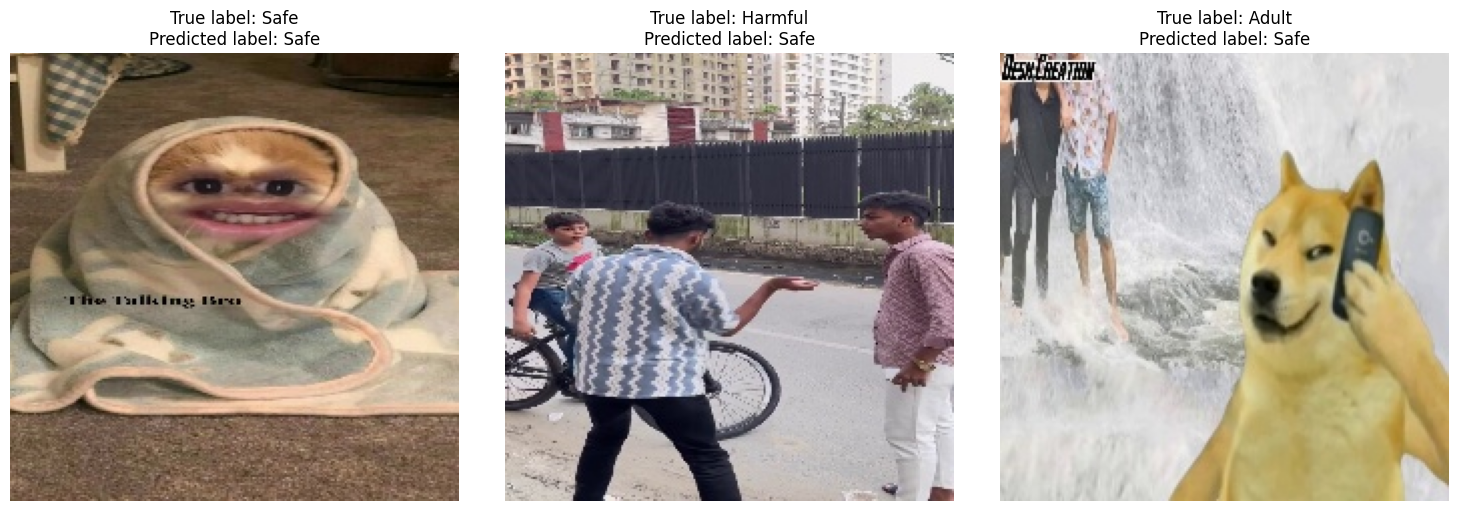

In [30]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Load the saved model weights
model_ft.load_state_dict(torch.load('clip_finetuned.pth'))
model_ft.eval()  # Set the model to evaluation mode

# Define the indices for the three images
indices = [0, 2, 10]

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Get the image and label from the dataset
    item = dataset[idx]
    image = item['image']
    true_label = item['labels']
    true_label = subcategories[true_label]

    # Transform the image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = subcategories[predicted_label_idx.item()]

    # Display the image in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}')
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [34]:
cm = confusion_matrix(y_true, y_pred)

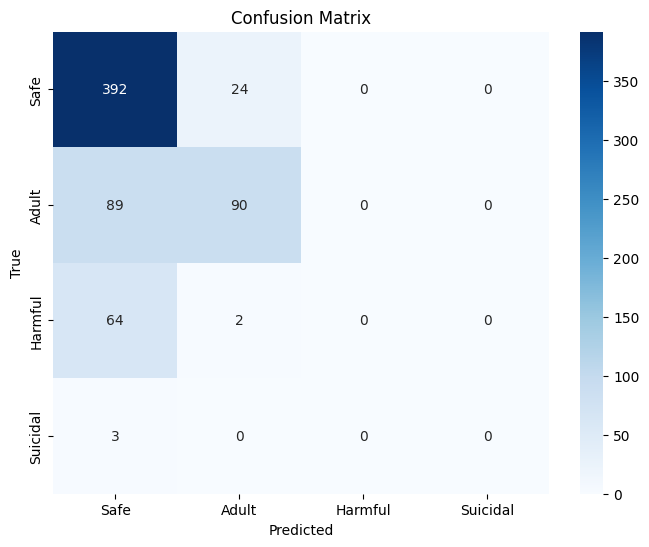

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(subcategories.values()),
            yticklabels=list(subcategories.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=list(subcategories.values())))

              precision    recall  f1-score   support

        Safe       0.72      0.94      0.81       416
       Adult       0.78      0.50      0.61       179
     Harmful       0.00      0.00      0.00        66
    Suicidal       0.00      0.00      0.00         3

    accuracy                           0.73       664
   macro avg       0.37      0.36      0.36       664
weighted avg       0.66      0.73      0.67       664



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
